<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Classifying Document**

Estimated time needed: **60** minutes

Imagine working at a prestigious newspaper or magazine company that boasts an extensive archive of documents dating back through the annals of time. Amid this treasure trove of information, a monumental task lies ahead: organizing these historical documents into their relevant topic sections. This strategic curation not only promises to enhance the user experience by delivering more streamlined content but also presents an opportunity to breathe new life into invaluable insights from the past through a modern lens. However, the sheer volume and scope of this undertaking call for a sophisticated solution. 

![Documents Overload](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0Y15EN/docs.png)

The implementation of an automated machine learning system makes it very efficient. Such a system, equipped with advanced natural language processing and machine learning capabilities, could sift through the vast archives, categorizing articles into their respective topics with remarkable precision. As a result, readers would seamlessly access a wealth of knowledge tailored to their interests, while the editorial team gains newfound agility in content management.

In this project, you will embark on the exciting task of classifying news articles for a content search engine. The goal is to build a model that can automatically categorize news articles into different topics or classes, enabling the search engine to deliver relevant content to users efficiently. To achieve this, you will leverage the powerful torchtext library, which simplifies the process of creating a dataset for text classification analysis.

With torchtext, you'll have the flexibility to access and preprocess raw news data effortlessly. The library enables you to convert text strings into torch.Tensors, which are essential for training machine learning models. By using torchtext's convenient functionalities, you can set up an efficient data processing pipeline that prepares your text data for classification.

Throughout this tutorial, you'll demonstrate how to effectively shuffle and iterate through the processed data using torch.utils.data.DataLoader. This DataLoader simplifies the data handling process, allowing you to focus on building and training your text classification model effectively.


---


# __Table of Contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-required-libraries">Installing required libraries</a></li>
            <li><a href="#Importing-required-libraries">Importing required libraries</a></li>
            <li><a href="#Defining-helper-functions">Defining helper functions</a></li>
        </ol>
    </li>
    <li>
        <a href="#Text-classification">Text classification</a></li>
        <ol>
            <li><a href="#Import-bank-data-set">Import bank dataset</a></li>
            <li><a href="#Data-set">Dataset</a></li>
            <li><a href="#Data-loader">Data loader</a></li>
            <li><a href="#Neural-network">Neural network</a></li>
        </ol>
    <li><a href="#Train-the-model">Train The model</a></li>
    <li><a href="#Exercises">Exercises</a></li>
</ol>


# Objectives

After completing this lab, you will be able to:

- Work with datasets and understand tokenizer, embedding bag technique and vocabulary.
- Explore embeddings in PyTorch and understand token indices.
- Perform text classification using data loader and apply it on a neural network model.
- Train the text classification model on a news dataset.
- Engage in various exercises to solidify your understanding.


# Setup


## Install the Libraries

<h2 style="color:red;">After installing the libraries below please RESTART THE KERNEL and run all cells.</h2>



For this lab, you will use the following libraries:


In [1]:
# # All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# !pip install -qy pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==0.20.1
# # - Update a specific package
# !pip install pmdarima -U
# # - Update a package to specific version
# !pip install --upgrade pmdarima==2.0.2
# # Note: If your environment doesn't support "!pip install", use "!mamba install"

The following required libraries are __not__ pre-installed in the Skills Network Labs environment. __You will need to run the following cell__ to install them:


In [2]:
# !pip install -Uqq portalocker>=2.0.0
# !pip install -qq torchtext
# !pip install -qq torchdata
# !pip install -Uqq plotly
# !pip install -qq dash

### Importing required libraries


In [3]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import numpy as np
from torchtext.datasets import AG_NEWS
from IPython.display import Markdown as md
from tqdm import tqdm

from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import AG_NEWS
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from sklearn.manifold import TSNE
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split

from torchtext.data.utils import get_tokenizer

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

### Defining helper functions

_Use this section to define any helper functions to help the notebook's code readability:_


In [4]:
def plot(COST,ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()

---


The gif below gives you an overview.

![nlp](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0Y15EN/NLP.gif)


---


## Text classification
Let's build a text classification model using PyTorch and torchtext to classify news articles into one of the four categories: World, Sports, Business, and Sci/Tech.


### Import bank dataset

Load the AG_NEWS dataset for the train split and split it into input text and corresponding labels:


In [5]:
train_iter= iter(AG_NEWS(split="train"))

The AG_NEWS dataset in torchtext does not support direct indexing like a list or tuple. It is not a random access dataset but rather an iterable dataset that needs to be used with an iterator. This approach is more effective for text data.


In [6]:
y,text= next((train_iter))
print(y,text)

3 Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


Find the label of the sample.


In [7]:
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}
ag_news_label[y]

'Business'

Also, use the dataset to find all the classes.


In [8]:
num_class = len(set([label for (label, text) in train_iter ]))
num_class 

4

Create the tokens as explained in previous lab and also build the vocabulary as before, just using the AG dataset to obtain token indices


In [9]:
# Reinitialize train_iter
train_iter = AG_NEWS(split="train")

# Define tokenizer and yield_tokens
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text.lower())  # Lowercase conversion for consistency

# Build vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Print the vocabulary size and sample tokens
print(f"Vocabulary size: {len(vocab)}")
print(f"Sample tokens: {list(vocab.get_stoi().keys())[:10]}")


Vocabulary size: 95811
Sample tokens: ['zyprexa', 'zwiki', 'zurab', 'zuhua', 'zubrin', 'zovko', 'zotinca', 'zos', 'zoology', 'zoner']


Here are some token indices:


In [10]:
vocab(["age","hello"])

[2120, 12544]

### Dataset 


You can convert the dataset into map-style datasets and then perform a random split to create separate training and validation datasets. The training dataset will contain 95% of the samples, while the validation dataset will contain the remaining 5%. These datasets can be used for training and evaluating a machine learning model for text classification on the AG_NEWS dataset.


In [11]:
# Split the dataset into training and testing iterators.
train_iter, test_iter = AG_NEWS()

# Convert the training and testing iterators to map-style datasets.
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train = int(len(train_dataset) * 0.95)

# Randomly split the training dataset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

The code checks if a CUDA-compatible GPU is available in the system using PyTorch, a popular deep learning framework. If a GPU is available, it assigns the device variable to "cuda" (which stands for CUDA, the parallel computing platform and application programming interface model developed by NVIDIA). If a GPU is not available, it assigns the device variable to "cpu" (which means the code will run on the CPU instead).


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Data loader


Prepare the text processing pipeline with the tokenizer and vocabulary. The text and label pipelines will be used to process the raw data strings from the dataset iterators. 

The function **```text_pipeline```** will tokenize the input text, and **```vocab```** will then be applied to get the token indices. 
The **```label_pipeline```** will ensure that the labels start at zero.


In [13]:
def text_pipeline(x):
  return vocab(tokenizer(x))

def label_pipeline(x):
   return int(x) - 1

In PyTorch, the **`collate_fn`** function is used in conjunction with data loaders to customize the way batches are created from individual samples. The provided code defines a `collate_batch` function in PyTorch, which is used with data loaders to customize batch creation from individual samples. It processes a batch of data, including labels and text sequences. It applies the `label_pipeline` and `text_pipeline` functions to preprocess the labels and texts, respectively. The processed data is then converted into PyTorch tensors and returned as a tuple containing the label tensor, text tensor, and offsets tensor representing the starting positions of each text sequence in the combined tensor. The function also ensures that the returned tensors are moved to the specified device (e.g., GPU) for efficient computation.


In [14]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

Convert the dataset objects to a data loader by applying the collate function.


In [15]:
BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

You can observe the output sequence when you have the label, text, and offsets for each batch.


In [16]:
label, text, offsets=next(iter(valid_dataloader ))
label, text, offsets

(tensor([3, 3, 3, 0, 2, 3, 2, 3, 3, 0, 1, 1, 0, 2, 1, 3, 2, 0, 0, 3, 3, 1, 2, 1,
         1, 1, 2, 1, 1, 2, 0, 1, 0, 1, 2, 1, 2, 2, 3, 3, 1, 3, 2, 0, 2, 2, 3, 3,
         0, 0, 3, 1, 0, 1, 2, 1, 2, 3, 3, 2, 0, 1, 3, 2]),
 tensor([  12, 5218,  120,  ...,    9,  294,    1]),
 tensor([   0,   51,   93,  140,  185,  220,  253,  320,  359,  387,  433,  479,
          515,  545,  585,  605,  648,  689,  746,  798,  853,  886,  932,  971,
         1021, 1055, 1090, 1140, 1176, 1235, 1263, 1308, 1365, 1407, 1488, 1532,
         1575, 1620, 1676, 1704, 1745, 1768, 1827, 1883, 1934, 1976, 2019, 2053,
         2104, 2132, 2178, 2229, 2298, 2374, 2427, 2473, 2512, 2547, 2587, 2635,
         2671, 2717, 2769, 2853]))

### Neural network


You have created a neural network for a text classification model using an `EmbeddingBag` layer, followed by a softmax output layer. Additionally, you have initialized the model using a specific method.


In [17]:
from torch import nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

You have created the model, and the embedding dimension size is a free parameter.


In [18]:
emsize=64

You need the vocabulary size to determine the number of embeddings.


In [19]:
vocab_size=len(vocab)
vocab_size

95811

You have also determined the number of classes for the output layer.


In [20]:
num_class 

4

Creating the model:


In [21]:
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)
model

TextClassificationModel(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

The code line `predicted_label=model(text, offsets)` is used to obtain predicted labels from a machine learning model for a given input text and its corresponding offsets. The `model` is the machine learning model being used for text classification or similar tasks.


In [22]:
predicted_label=model(text, offsets)

Now, verify the output shape of your model. In this case, the model is trained with a mini-batch size of 64 samples. The output layer of the model produces four logits for each neuron, corresponding to the four classes in the classification task. You can also create a function to find the accuracy given a dataset.


In [23]:
predicted_label.shape

torch.Size([64, 4])

Function **`predict`** takes in a text and a text pipeline, which preprocesses the text for machine learning. It uses a pre-trained model to predict the label of the text for text classification on the AG_NEWS dataset. The function returns the predicted label as a result.


In [24]:
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return ag_news_label[output.argmax(1).item() + 1]

In [25]:
predict("I like sports",text_pipeline )

'Business'

Create a function to evaluate the model's accuracy on a dataset.


In [26]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

The model was evaluated, and it was found that its performance is no better than average. This outcome is expected, considering that the model has not undergone any training yet.


In [27]:
evaluate(test_dataloader)

0.2326315789473684

Let's train the model.


---


## Train the model

Set the learning rate (LR) to 0.1, which determines the step size at which the optimizer updates the model's parameters during training. The CrossEntropyLoss criterion is used to calculate the loss between the model's predicted outputs and the ground truth labels. This loss function is commonly employed for multi-class classification tasks.

The chosen optimizer is Stochastic Gradient Descent (SGD), which optimizes the model's parameters based on the computed gradients with respect to the loss function. The SGD optimizer uses the specified learning rate to control the size of the weight updates.

Additionally, a learning rate scheduler is defined using StepLR. This scheduler adjusts the learning rate during training, reducing it by a factor (gamma) of 0.1 after every epoch (step) to improve convergence and fine-tune the model's performance. These components together form the essential setup for training a neural network using the specified learning rate, loss criterion, optimizer, and learning rate scheduler.


In [28]:
LR=0.1

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

Training the model, which should take about 20 minutes.


In [29]:
EPOCHS = 10
cum_loss_list=[]
acc_epoch=[]
acc_old=0

for epoch in tqdm(range(1, EPOCHS + 1)):
    model.train()
    cum_loss=0
    for idx, (label, text, offsets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        cum_loss+=loss.item()

    cum_loss_list.append(cum_loss)
    accu_val = evaluate(valid_dataloader)
    acc_epoch.append(accu_val)

    if accu_val > acc_old:
      acc_old= accu_val
      torch.save(model.state_dict(), 'my_model.pth')

100%|██████████| 10/10 [01:39<00:00,  9.93s/it]


You can plot the cost and accuracy for each epoch. You'll see that with just ten epochs, you achieve an accuracy of over 80% on the validation data. You can increase the number of epochs to observe further results.


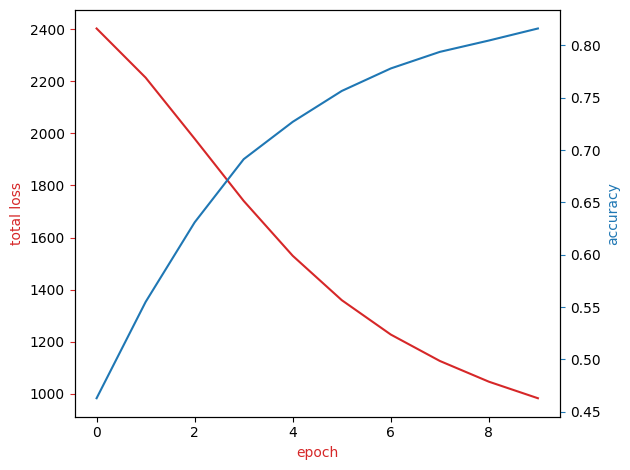

In [30]:
plot(cum_loss_list,acc_epoch)

You can evaluate the results on the test data and achieve over 80%.


In [31]:
evaluate(test_dataloader)

0.8139473684210526

This code snippet provides a summary for generating a 3D t-SNE visualization of embeddings using Plotly. It demonstrates how words that are similar to each other are positioned closer together.


In [32]:
# Get the first batch from the validation data
batch = next(iter(valid_dataloader))

# Extract the text and offsets from the batch
label, text, offsets = batch

# Send the data to the device (GPU if available)
text = text.to(device)
offsets = offsets.to(device)

# Get the embeddings bag output for the batch
embedded = model.embedding(text, offsets)

# Convert the embeddings tensor to a numpy array
embeddings_numpy = embedded.detach().cpu().numpy()

# Perform t-SNE on the embeddings to reduce their dimensionality to 3D.
X_embedded_3d = TSNE(n_components=3).fit_transform(embeddings_numpy)

# Create a 3D scatter plot using Plotly
trace = go.Scatter3d(
    x=X_embedded_3d[:, 0],
    y=X_embedded_3d[:, 1],
    z=X_embedded_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=label.numpy(),  # Use label information for color
        colorscale='Viridis',  # Choose a colorscale
        opacity=0.8
    )
)

layout = go.Layout(title="3D t-SNE Visualization of Embeddings",
                   scene=dict(xaxis_title='Dimension 1',
                              yaxis_title='Dimension 2',
                              zaxis_title='Dimension 3'))

fig = go.Figure(data=[trace], layout=layout)
fig.show()

You can make a prediction on the following article using the function **`predict`**.


In [ ]:
article="""Canada navigated a stiff test against the Republic of Ireland on a rain soaked evening in Perth, coming from behind to claim a vital 2-1 victory at the Women's World Cup.
Katie McCabe opened the scoring with an incredible Olimpico goal - scoring straight from a corner kick - as her corner flew straight over the despairing Canada goalkeeper Kailen Sheridan at Perth Rectangular Stadium in Australia.
Just when Ireland thought it had safely navigated itself to half time with a lead, Megan Connolly failed to get a clean connection on a clearance with the resulting contact squirming into her own net to level the score.
Minutes into the second half, Adriana Leon completed the turnaround for the Olympic champion, slotting home from the edge of the area to seal the three points."""

This markdown content generates a styled box with light gray background and padding. It contains an `<h3>` header displaying the content of the `article` variable, and an `<h4>` header indicating the predicted category of the news article which is provided by the `result` variable. The placeholders `{article}` and `{result}` will be dynamically replaced with actual values when this markdown is rendered.


In [34]:
result = predict(article, text_pipeline)

markdown_content = f'''
<div style="background-color: lightgray; padding: 10px;">
    <h3>{article}</h3>
    <h4>The category of the news article: {result}</h4>
</div>
'''

md(markdown_content)


<div style="background-color: lightgray; padding: 10px;">
    <h3>Canada navigated a stiff test against the Republic of Ireland on a rain soaked evening in Perth, coming from behind to claim a vital 2-1 victory at the Women’s World Cup.
Katie McCabe opened the scoring with an incredible Olimpico goal – scoring straight from a corner kick – as her corner flew straight over the despairing Canada goalkeeper Kailen Sheridan at Perth Rectangular Stadium in Australia.
Just when Ireland thought it had safely navigated itself to half time with a lead, Megan Connolly failed to get a clean connection on a clearance with the resulting contact squirming into her own net to level the score.
Minutes into the second half, Adriana Leon completed the turnaround for the Olympic champion, slotting home from the edge of the area to seal the three points.</h3>
    <h4>The category of the news article: Sports</h4>
</div>


Looks good!


# Exercises


### Exercise 1 - Load the pre-trained model (path = 'my_model.pth').


In [36]:
model.load_state_dict(torch.load('my_model.pth'))
model.eval()

TextClassificationModel(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

<details>
    <summary>Click here for Solution</summary>

```python
model.load_state_dict(torch.load('my_model.pth'))
model.eval()
```

</details>


### Exercise 2 - Define the list of new articles for classification.


In [37]:
new_articles = [
    "The stock market is experiencing a significant downturn, with major indices falling sharply.",
    "A new study reveals the health benefits of a Mediterranean diet, including reduced risk of heart disease.",
    "The local sports team won their championship game in a thrilling overtime finish.",
    "Scientists have discovered a new exoplanet that may have conditions suitable for life."
]

<details>
    <summary>Click here for Solution</summary>

```python
new_articles = [
    "International talks have made significant headway with the signing of a climate accord that commits countries to reduce emissions by 40% over the next two decades. World leaders expressed optimism at the conclusion of the summit.",
    "In a stunning upset, the underdog team won the national title, beating the favorites in a match that featured an incredible comeback and a last-minute goal that sealed their victory in front of a record crowd.",
    "Market analysts are optimistic as the tech startup's stock prices soared after the announcement of their latest product, which promises to revolutionize how we interact with smart devices.",
    "A recent study published in a leading scientific journal suggests that a new drug has shown promise in the treatment of Alzheimer's disease, outperforming current leading medications in early clinical trials.",
    "Diplomatic relations have taken a positive turn with the recent peace talks that aim to end decades of conflict. The ceasefire agreement has been welcomed by the international community.",
    "Economic indicators show a sharp rebound in manufacturing, with the automobile industry leading the charge. Analysts predict this surge will result in significant job creation over the next year.",
    "Researchers at the university's astrophysics department have discovered a potentially habitable exoplanet. The planet, which lies in a nearby star system, has conditions that could support liquid water and, possibly, life.",
    "The sports world is in shock as a legendary player announces their retirement. Over an illustrious 20-year career, the athlete has amassed numerous records and is regarded as one of the greatest to ever play the game.",
    "A multinational corporation has announced a major investment in renewable energy. The initiative includes the construction of new wind farms and solar panels that will power hundreds of thousands of homes.",
    "Climate scientists warn that the melting of the polar ice caps has been accelerating at an alarming rate, raising sea levels and threatening coastal cities worldwide with increased flooding risks."
]
```

</details>


### Exercise 3 - Classify each article and display the results.


In [39]:
for i, article in enumerate(new_articles):
    result = predict(article, text_pipeline)
    markdown_content = f'''
    <div style="background-color: lightgray; padding: 10px;">
        <h3>Article {i+1}: {article}</h3>
        <h4>The category of the news article: {result}</h4>
    </div>
    '''
    display(md(markdown_content))


    <div style="background-color: lightgray; padding: 10px;">
        <h3>Article 1: The stock market is experiencing a significant downturn, with major indices falling sharply.</h3>
        <h4>The category of the news article: Business</h4>
    </div>
    


    <div style="background-color: lightgray; padding: 10px;">
        <h3>Article 2: A new study reveals the health benefits of a Mediterranean diet, including reduced risk of heart disease.</h3>
        <h4>The category of the news article: Sci/Tec</h4>
    </div>
    


    <div style="background-color: lightgray; padding: 10px;">
        <h3>Article 3: The local sports team won their championship game in a thrilling overtime finish.</h3>
        <h4>The category of the news article: Sports</h4>
    </div>
    


    <div style="background-color: lightgray; padding: 10px;">
        <h3>Article 4: Scientists have discovered a new exoplanet that may have conditions suitable for life.</h3>
        <h4>The category of the news article: Sci/Tec</h4>
    </div>
    

<details>
    <summary>Click here for Solution</summary>

```python
for i, article in enumerate(new_articles, start=1):
    prediction = predict(article, text_pipeline)
    print(f"Article {i} is classified as: {prediction}\n")
```

</details>


---


## Congratulations! You have completed the lab


## Authors


[Joseph Santarcangelo](https://author.skills.network/instructors/joseph_santarcangelo)

Joseph has a Ph.D. in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


[Roodra Kanwar](https://www.linkedin.com/in/roodrakanwar/) is completing his MS in CS specializing in big data from Simon Fraser University. He has previous experience working with machine learning and as a data engineer.


## References 


[TEXT CLASSIFICATION WITH THE TORCHTEXT LIBRARY](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html)


```{## Change log}
```


```{|Date (YYYY-MM-DD)|Version|Changed By|Change Description||-|-|-|-||2023-07-27|0.1|Joseph|Created Lab||2023-07-31|0.1|Roodra|Updated Lab|}
```


© Copyright IBM Corporation. All rights reserved.
